<a href="https://colab.research.google.com/github/aashishpiitk/EE603-Project/blob/main/CNN_SED_Training_Notebook_direct_script_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -r /content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/requirements.txt

In [ ]:
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [ ]:
import numpy as np
import os
import librosa
import librosa.display

In [ ]:
! pip install dcase_util
import dcase_util

In [ ]:
import dcase_util
from dcase_util.containers import AudioContainer
import os, numpy
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sed_eval
%matplotlib inline

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = '/content/data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features_sed')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)

# Filename for acoustic model
model_filename = os.path.join(data_storage_path, 'model_sed.h5')  

# def get_feature_filename(audio_filename, feature_storage_path):
#     """Get feature filename from audio filename. """
    
#     return dcase_util.utils.Path(path=audio_filename).modify(
#         path_base=feature_storage_path, 
#         filename_extension='.npy'
#     )
    
# def get_feature_matrix(audio_filename, feature_storage_path=os.path.join('data', 'features_sed')):  
#     """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
#     feature_filename = get_feature_filename(audio_filename, feature_storage_path)
#     if os.path.exists(feature_filename):
#         return numpy.load(feature_filename)
#     else:
#         audio = dcase_util.containers.AudioContainer().load(filename=audio_filename,mono=True)
#         mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs)
#         mel_data = mel_extractor.extract(y=audio)
#         numpy.save(feature_filename, mel_data)
#         return mel_data
    
# Setup Keras to use tensorflow as backend
dcase_util.keras.setup_keras(backend='tensorflow')
import keras
from keras.layers import *
from keras.models import Model

In [ ]:
def readAudio(filename):
    x, sr = librosa.load(filename, sr=16000)
    return x, sr

#calculate spectrogram
def calc_spec(x):
    n_fft = 1024
    hop_length = 512
    win_length = 1024
    X = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann', dtype = np.complex256))
    X = librosa.power_to_db(X**2,ref=np.max)
    return X

In [ ]:
import librosa
def get_feature_matrix(audio_filename_path):  
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    audio, fs = librosa.load(audio_filename_path)
    hop_len = 0.02
    mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=hop_len, fs = fs)
    mel_data = mel_extractor.extract(y=audio)
    #numpy.save(feature_filename, mel_data)
    return mel_data, hop_len
        

In [ ]:
import librosa
def get_feature_matrix_script_features(audio_filename_path):  
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    audio, fs = librosa.load(audio_filename_path, sr = 16000)
    mel_data = calc_spec(audio)
    # hop_len = 0.02
    # mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=hop_len, fs = fs)
    # mel_data = mel_extractor.extract(y=audio)
    #numpy.save(feature_filename, mel_data)

    return mel_data, 10/mel_data.shape[1]
        

In [ ]:
# print(get_feature_matrix_script_features('/content/S001.wav')[1], get_feature_matrix('/content/S001.wav')[1])

In [ ]:
def csv_to_meta_container(csv_file_path):
  dict_container = dcase_util.containers.ListDictContainer(filename = csv_file_path)
  dict_container.load()
  train_meta = dcase_util.containers.MetaDataContainer(dict_container)
  print(train_meta)
  return train_meta

In [ ]:
train_meta = csv_to_meta_container('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/dataset_updated/labels_updated.csv')

MetaDataContainer :: Class
Items                               : 2160 
Unique
  Files                             : 1020 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Meta data
  Source                  Onset   Offset   Scene             Event             Tags              Identifier   
  --------------------   ------   ------   ---------------   ---------------   ---------------   -----   
  S1                       0.00     5.00   -                 music             -                 -       
  S1                       5.00    10.00   -                 speech            -                 -       
  S2                       0.00     5.00   -                 music             -                 -       
  S2                       5.00    10.00   -                 speech            -                 -       
  S3                 

In [ ]:
X_train = []
Y_train = []
audio_folder_name = '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/dataset_updated/wav_updated'
for audio_filename in os.listdir(audio_folder_name):#os.listdir() s1.wav, s2.wav
    #print('Load', db.absolute_to_relative_path(audio_filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    audio_path = os.path.join(audio_folder_name, audio_filename)
    features, hop_length_seconds = get_feature_matrix_script_features(audio_path)
    #features = features#features[:,:450] 
    #feature_sequence = data_sequencer.sequence(features)
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    event_list = train_meta.filter(filename=audio_filename.split('.')[0])
    event_roll = event_list.to_event_roll(
        label_list = ['speech', 'music'],                                       # Event labels
        time_resolution = hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds = features.shape[1] * hop_length_seconds   # Length of original audio signal
    ).data
    #target_matrix = data_sequencer.sequence(event_roll)
    
    # print(features.shape, event_roll.shape)
    # print(type(features), type(np.array(event_roll.data)))
    X_train.append(features) 
    Y_train.append(np.array(event_roll))

print(len(Y_train))  
X_train = np.stack(X_train)
Y_train = np.stack(Y_train)
Y_train = np.moveaxis(Y_train, 1, 2)
print('----------------------')
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)

1008
----------------------
X_train shape (1008, 513, 313)
Y_train shape (1008, 313, 2)


In [ ]:
# import numpy as np
# np.save('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/X_train_script_features_new.npy', X_train)
# np.save('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/Y_train_script_features_new.npy', Y_train)

In [ ]:
# import numpy as np
# np.save('/content/X_train_script_features.npy', X_train)
# np.save('/content/Y_train_script_features.npy', Y_train)

In [ ]:
import numpy as np
def load_features_and_labels(features_path, labels_path):
  X = np.load(features_path)
  Y = np.load(labels_path)
  return X, Y

In [ ]:
# a, b = load_features_and_labels('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/X_train_script_features.npy', '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/Y_train_script_features.npy')

In [ ]:
# print(a.shape, b.shape)

In [ ]:
# X_train, Y_train = load_features_and_labels('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/X_train_script_features.npy', '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/Y_train_script_features.npy')

In [ ]:
# a = np.load('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/X_train_script_features.npy')

In [ ]:
# print(X_train.shape, Y_train.shape)

In [ ]:
# ! rm -r '/content/audio_files/.ipynb_checkpoints'

In [ ]:
validation_meta = csv_to_meta_container('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/dataset_updated/labels_updated.csv')

MetaDataContainer :: Class
Items                               : 2160 
Unique
  Files                             : 1020 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Meta data
  Source                  Onset   Offset   Scene             Event             Tags              Identifier   
  --------------------   ------   ------   ---------------   ---------------   ---------------   -----   
  S1                       0.00     5.00   -                 music             -                 -       
  S1                       5.00    10.00   -                 speech            -                 -       
  S2                       0.00     5.00   -                 music             -                 -       
  S2                       5.00    10.00   -                 speech            -                 -       
  S3                 

In [ ]:
X_validation = []
Y_validation = []
validation_data = {}
audio_folder_name = '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/validation_data/validation_wavs'
for audio_filename in os.listdir(audio_folder_name):#os.listdir() s1.wav, s2.wav
    #print('Load', db.absolute_to_relative_path(audio_filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    audio_path = os.path.join(audio_folder_name, audio_filename)
    features, hop_length_seconds = get_feature_matrix_script_features(audio_path)
    features = features[:,:500] 
    #feature_sequence = data_sequencer.sequence(features)
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    event_list = validation_meta.filter(filename=audio_filename.split('.')[0])
    event_roll = event_list.to_event_roll(
        label_list = ['speech', 'music'],                                       # Event labels
        time_resolution = hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds = features.shape[1] * hop_length_seconds   # Length of original audio signal
    ).data
    #target_matrix = data_sequencer.sequence(event_roll)
    
    # print(features.shape, event_roll.shape)
    # print(type(features), type(np.array(event_roll.data)))
    X_validation.append(features) 
    Y_validation.append(np.array(event_roll))

    validation_data[audio_filename] = {
        'features' : features,
        'meta' : event_list
    }
    
X_validation = np.stack(X_validation)
Y_validation = np.stack(Y_validation)
Y_validation = np.moveaxis(Y_validation, 1, 2)
print('----------------------')
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

----------------------
X_validation shape (12, 513, 313)
Y_validation shape (12, 313, 2)


In [ ]:
# print(validation_data)

In [ ]:
# X_validation, Y_validation = load_features_and_labels

Next we create **CRNN** styled neural network structure layer by layer


**Input** layer and **Reshaping** layer to add channel axis into input to match `channels_last` mode:

In [ ]:
feature_vector_length = 513   # Number of mel bands
sequence_length = 313

In [ ]:
print(feature_vector_length)

513


In [ ]:
input_layer = Input(
    shape=(feature_vector_length, sequence_length), 
    name='Input'
)
x = Reshape(
    target_shape=(feature_vector_length, sequence_length, 1), 
    name='Input_Reshape'
)(input_layer)


In [ ]:
print('Output shape','(sequence, frequency, time, channel)', x.shape)

Output shape (sequence, frequency, time, channel) (None, 513, 313, 1)


**Two convolutional groups** are used to capture small shifts in time and frequency. 

Similar groups as in sound classification example, except max **pooling done only along frequency** axis as time axis is retained for the detection.


In [ ]:
print('Input shape','(sequence, frequency, time, channel)', x.shape)

Input shape (sequence, frequency, time, channel) (None, 513, 313, 1)


In [ ]:
# Convolution
x = Conv2D(filters=64, kernel_size=(3, 3), activation='linear', kernel_initializer='random_normal',
           padding='same', data_format='channels_last', name='Conv1')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv1_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv1_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(5, 1), name='Conv1_Pooling')(x)
# Drop out
x = Dropout(rate=0.2, name='Conv1_DropOut')(x)


In [ ]:
print('Output shape', '(sequence, frequency, time, feature)', x.shape)

Output shape (sequence, frequency, time, feature) (None, 102, 313, 64)


In [ ]:
print('Input shape','(sequence, frequency, time, channel)', x.shape)

Input shape (sequence, frequency, time, channel) (None, 102, 313, 64)


In [ ]:
# Convolution
x = Conv2D(filters=64, kernel_size=(3, 3), activation='linear', kernel_initializer='random_normal',
           padding='same', data_format='channels_last', name='Conv2')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv2_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv2_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(4, 1), name='Conv2_Pooling')(x)
# Drop out
x = Dropout(rate=0.2, name='Conv2_DropOut')(x)


In [ ]:
print('Output shape', '(sequence, frequency, time, feature)', x.shape)

Output shape (sequence, frequency, time, feature) (None, 25, 313, 64)


To **connect** convolutional layers and recurrent layers, output of the last convolutional group has to be  **Reordered** and **Reshaped**:

In [ ]:
print('Input shape', '(sequence, frequency, time, feature)', x.shape)

Input shape (sequence, frequency, time, feature) (None, 25, 313, 64)


In [ ]:
x = Permute(
    dims=(1, 3, 2), 
    name='Permute'
)(x)

x = Reshape(
    target_shape=(sequence_length, -1), 
    name='Reshape'
)(x)


In [ ]:
print('Output shape', '(sequence, time, feature)', x.shape)

Output shape (sequence, time, feature) (None, 313, 1600)


Two **bidirectional** **recurrent** layers (Gated Recurrent Units) are used to integrate information from large time window:

In [ ]:
# print('Input shape', '(sequence, time, feature)', x.shape)

In [ ]:
# x = Bidirectional(
#     SimpleRNN(
#         units=32, activation='tanh', 
#         dropout=0.2, recurrent_dropout=0.2, 
#         return_sequences=True, kernel_initializer='random_normal'
#     ), merge_mode='mul', name='Recurrent_1'
# )(x)
# x = Bidirectional(
#     SimpleRNN(units=32, activation='tanh', 
#         dropout=0.2, recurrent_dropout=0.2, 
#         return_sequences=True, kernel_initializer='random_normal'
#     ), merge_mode='mul', name='Recurrent_2'
# )(x)

In [ ]:
# print('Output shape', '(sequence, time, feature)', x.shape)

**Recognition** is done with two **fully-connected** layers using information extracted by the previous layers. 

Layers are wrapped with `TimeDistributed` class to apply layers independently to each time step.

**Output layer** (last fully-connected layer) is with sigmoid activation.

In [ ]:
x = TimeDistributed(
    Dense(units=32, kernel_initializer='random_normal'), name='FC1', 
)(x)
x = Dropout(rate=0.2, name='FC_DropOut')(x)
x = TimeDistributed(
    Dense(units=2, kernel_initializer='random_normal'), name='Output'
)(x)
output_layer = Activation('sigmoid', name='Output_Activation')(x)

In [ ]:
print('Output shape', '(sequence, time, classes)', output_layer.shape)

Output shape (sequence, time, classes) (None, 313, 2)


Create a model network:

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# del FC1

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 513, 313)]        0         
                                                                 
 Input_Reshape (Reshape)     (None, 513, 313, 1)       0         
                                                                 
 Conv1 (Conv2D)              (None, 513, 313, 64)      640       
                                                                 
 Conv1_BatchNorm (BatchNorma  (None, 513, 313, 64)     256       
 lization)                                                       
                                                                 
 Conv1_Activation (Activatio  (None, 513, 313, 64)     0         
 n)                                                              
                                                                 
 Conv1_Pooling (MaxPooling2D  (None, 102, 313, 64)     0     

## Training

One should evaluate validation data with **same metric** which is used in actual system evaluation with test set 

For sound event detection, `keras` does not provide any suitable metric (such as *segment-based error rate (ER)* or *f-score (F1)*)

Default `keras` training process needs to be modified by halting it after each epoch:
- Validation data is evaluated with current model **outside the training process**
- Metric values are stored and used to control the training process (e.g. model selection or early stopping)

## Callbacks

In [ ]:
!pip install colorama

In [ ]:
epochs = 100
keras_metric = 'binary_accuracy'
keras_loss = 'binary_crossentropy'
metric_to_monitor = 'ER'
external_metrics = {
    'ER': 'Error rate',
    'F1': 'F-score'
}

callback_list = [
    dcase_util.tfkeras.ProgressLoggerCallback(
        epochs=epochs,
        metric=keras_metric,
        loss=keras_loss,
        output_type='console',
        show_timing=False,
        manual_update=True,
        external_metric_labels=external_metrics        
    ),
    #dcase_util.keras.StopperCallback(
    #    epochs=epochs,
    #    monitor=metric_to_monitor,
    #    patience=10,
    #    initial_delay=50,
    #    min_delta=0,
    #    manual_update=True,
    #    external_metric_labels=external_metrics
    #),
    dcase_util.tfkeras.StasherCallback(
        epochs=epochs,
        monitor=metric_to_monitor,
        initial_delay=50,
        manual_update=True,
        external_metric_labels=external_metrics
    )
]

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(
    loss=keras_loss,
    metrics=[keras_metric],
    optimizer=Adam(lr=0.001, decay=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Reorder target to fit model
Y_train = numpy.moveaxis(Y_train, 1, 2)
Y_validation = numpy.moveaxis(Y_validation, 1, 2)

print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

X_train shape (1008, 513, 313)
Y_train shape (1008, 2, 313)
X_validation shape (12, 513, 313)
Y_validation shape (12, 2, 313)


In [ ]:
from tensorflow.keras.callbacks import *

In [ ]:
X_train = X_train[:, :, :]
Y_train = Y_train[:, :, :]

In [ ]:
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

X_train shape (1008, 513, 313)
Y_train shape (1008, 2, 313)
X_validation shape (12, 513, 313)
Y_validation shape (12, 2, 313)


In [ ]:
# Reorder target to fit model
Y_train = numpy.moveaxis(Y_train, 2, 1)
Y_validation = numpy.moveaxis(Y_validation, 2, 1)

print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

X_train shape (1008, 513, 313)
Y_train shape (1008, 313, 2)
X_validation shape (12, 513, 313)
Y_validation shape (12, 313, 2)


In [ ]:
model = keras.models.load_model(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_sed_weights', f'model_seds_direct_script_upto_40_epochs.h5')) # Load model

In [ ]:
epochs = 50
# Variable to training history including metrics calculated outside keras
history_over_epochs = {
    'loss': [],
    'val_loss': [],
    'val_er': [],
    'val_f1': [],
    'binary_accuracy' : [],
    'val_binary_accuracy' : []
}

# Do training epoch by epoch
for epoch_start in range(10, 50):
    model.save(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_sed_weights', f'model_seds_direct_script_upto_{epoch_start}_epochs.h5'))

    # Save training history
    dcase_util.files.Serializer().save_cpickle(
        filename=os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_sed_weights', f'model_cnn_sed_training_history_upto_{epoch_start}_epochs.cpickle'),
        data=history_over_epochs
    )

    epoch_end = epoch_start + 1

    # Make sure we have only specified amount of epochs
    if epoch_end > epochs:
        epoch_end = epochs

    # Train model
    history = model.fit( x=X_train,        y=Y_train,        validation_data=(X_validation, Y_validation),
        callbacks= callback_list,
        verbose=0,
        initial_epoch=epoch_start,
        epochs=epoch_end,        batch_size=8,        shuffle=True
    )
    
    # Initialize evaluator
    evaluator = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=['speech', 'music'],
        time_resolution=1.0,
    )
    
    # Go through all validation files, do detection and accumulate intermediate statistics for metric calculation
    for audio_filename, validation_item in validation_data.items():
        # Get input features
        #input_data = data_sequencer.sequence(validation_item['features']).data
        input_data = validation_item['features']#numpy.moveaxis(validation_item['features'], 2, 0)
        input_data = np.expand_dims(input_data, 0)
        # Get per frame probabilities in sequences (3D matrix)
        item_probabilities_seq = model.predict(x=input_data)
        # Merge sequences together (2D matrix)
        item_probabilities = numpy.vstack(item_probabilities_seq)

        # Binarization 
        event_activity = dcase_util.data.ProbabilityEncoder().binarization(
            probabilities=item_probabilities,
            binarization_type='global_threshold',
            threshold=0.4
        )
        
        # Get list of detected events
        current_estimated = dcase_util.containers.MetaDataContainer()
        for event_id, event_label in enumerate(['speech', 'music']):
            # Convert active frames into segments and translate frame indices into timestamps
            event_segments = dcase_util.data.DecisionEncoder().find_contiguous_regions(
                activity_array=event_activity[:, event_id]
            ) * 0.03194888178

            # Form event items
            for event in event_segments:
                current_estimated.append(
                    {
                        'filename': audio_filename,
                        'onset': event[0],
                        'offset': event[1],
                        'event_label': event_label
                    }
                )
                
        # Accumulate evaluator with current file
        evaluator.evaluate(
            reference_event_list=validation_item['meta'],
            estimated_event_list=current_estimated
        )

    # Calculate metrics
    overall_metrics = evaluator.results_overall_metrics()
    er = overall_metrics['error_rate']['error_rate']
    fscore = overall_metrics['f_measure']['f_measure']

    # Inject external metric values to the callbacks
    for callback in callback_list:
        if hasattr(callback, 'set_external_metric_value'):
            callback.set_external_metric_value(
                metric_label='ER',
                metric_value=er
            )
            callback.set_external_metric_value(
                metric_label='F1',
                metric_value=fscore
            )

    # Store metrics
    history_over_epochs['loss'].append(history.history['loss'])
    history_over_epochs['val_loss'].append(history.history['val_loss'])
    history_over_epochs['val_er'].append(er)
    history_over_epochs['val_f1'].append(fscore)
    history_over_epochs['binary_accuracy'].append(history.history['binary_accuracy'])
    history_over_epochs['val_binary_accuracy'].append(history.history['val_binary_accuracy'])

    # Manually update callbacks
    for callback in callback_list:
        if hasattr(callback, 'update'):
            callback.update()

    # Check if we need to stop training
    stop_training = False
    for callback in callback_list:
        if hasattr(callback, 'stop'):
            if callback.stop():
                stop_training = True
                break

    if stop_training:
        # Stop the training loop
        break

    #model.save(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/crnn_gru_sed_weight', f'model_seds_direct_script_upto_{epochs}_epochs.h5'))
# Manually update callbacks
for callback in callback_list:
    if hasattr(callback, 'close'):
        callback.close()


# Save model
# model.save(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/crnn_gru_sed_weight', 'model_seds_direct_script_upto_10_epochs.h5'))

[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0101s vs `on_train_batch_end` time: 0.1394s). Check your callbacks.


  10        0.5344       0.5506       0.7308       0.7079       1.8857         0.5092        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0102s vs `on_train_batch_end` time: 0.1244s). Check your callbacks.


  11        0.5298       0.4977       0.7337       0.7599       1.2571         0.5592        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0103s vs `on_train_batch_end` time: 0.1370s). Check your callbacks.


  12        0.5275       0.6048       0.7357       0.6579       2.2714         0.4682        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0095s vs `on_train_batch_end` time: 0.1256s). Check your callbacks.


  13        0.5246       0.6260       0.7373       0.7133       1.4857         0.5316        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0097s vs `on_train_batch_end` time: 0.1260s). Check your callbacks.


  14        0.5218       0.5843       0.7385       0.7186       1.7143         0.5156        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0112s vs `on_train_batch_end` time: 0.1237s). Check your callbacks.


  15        0.5199       0.5154       0.7411       0.7431       1.2429         0.5592        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0096s vs `on_train_batch_end` time: 0.1289s). Check your callbacks.


  16        0.5163       0.5013       0.7428       0.7476       1.2143         0.5741        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0116s vs `on_train_batch_end` time: 0.1240s). Check your callbacks.


  17        0.5181       0.6208       0.7415       0.6601       2.2286         0.4678        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0103s vs `on_train_batch_end` time: 0.1325s). Check your callbacks.


  18        0.5154       0.5498       0.7462       0.7190       1.6143         0.5082        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0111s vs `on_train_batch_end` time: 0.1235s). Check your callbacks.


  19        0.5141       0.5225       0.7464       0.7447       1.8286         0.5169        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0101s vs `on_train_batch_end` time: 0.1362s). Check your callbacks.


  20        0.5148       0.5891       0.7434       0.6914       2.2286         0.4730        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0113s vs `on_train_batch_end` time: 0.1240s). Check your callbacks.


  21        0.5116       0.5563       0.7479       0.7134       1.8714         0.5111        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0094s vs `on_train_batch_end` time: 0.1260s). Check your callbacks.


  22        0.5134       0.5274       0.7478       0.7431       1.0857         0.5445        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0102s vs `on_train_batch_end` time: 0.1417s). Check your callbacks.


  23        0.5105       0.4994       0.7488       0.7540       1.5571         0.5207        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0093s vs `on_train_batch_end` time: 0.1262s). Check your callbacks.


  24        0.5096       0.4923       0.7494       0.7592       1.3571         0.5511        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0112s vs `on_train_batch_end` time: 0.1258s). Check your callbacks.


  25        0.5074       0.4797       0.7500       0.7672       1.5857         0.5520        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0103s vs `on_train_batch_end` time: 0.1240s). Check your callbacks.


  26        0.5066       0.5771       0.7505       0.6808       2.2571         0.4698        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0095s vs `on_train_batch_end` time: 0.1249s). Check your callbacks.


  27        0.5079       0.5015       0.7517       0.7423       1.8571         0.5130        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0098s vs `on_train_batch_end` time: 0.1320s). Check your callbacks.


  28        0.5057       0.4719       0.7529       0.7662       1.2143         0.5701        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0104s vs `on_train_batch_end` time: 0.1248s). Check your callbacks.


  29        0.5074       0.5582       0.7513       0.7405       1.2000         0.5926        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0099s vs `on_train_batch_end` time: 0.1262s). Check your callbacks.


  30        0.5048       0.5198       0.7529       0.7411       1.1143         0.5813        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0094s vs `on_train_batch_end` time: 0.1251s). Check your callbacks.


  31        0.5025       0.5652       0.7535       0.7073       1.9571         0.5000        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0094s vs `on_train_batch_end` time: 0.1258s). Check your callbacks.


  32        0.5037       0.4812       0.7530       0.7600       1.3857         0.5751        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0097s vs `on_train_batch_end` time: 0.1258s). Check your callbacks.


  33        0.5031       0.6134       0.7544       0.7435       1.2857         0.5740        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0096s vs `on_train_batch_end` time: 0.1265s). Check your callbacks.


  34        0.4995       0.5419       0.7560       0.7516       1.2000         0.5806        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0094s vs `on_train_batch_end` time: 0.1357s). Check your callbacks.


  35        0.5033       0.5158       0.7539       0.7200       1.8000         0.4981        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0096s vs `on_train_batch_end` time: 0.1256s). Check your callbacks.


  36        0.4993       0.5527       0.7558       0.7169       1.9143         0.5055        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0079s vs `on_train_batch_end` time: 0.1278s). Check your callbacks.


  37        0.5014       0.5788       0.7551       0.7114       1.4857         0.5439        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0105s vs `on_train_batch_end` time: 0.1244s). Check your callbacks.


  38        0.5012       0.5052       0.7553       0.7573       1.0857         0.5842        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0113s vs `on_train_batch_end` time: 0.1323s). Check your callbacks.


  39        0.4996       0.4673       0.7563       0.7714       1.2571         0.5830        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0096s vs `on_train_batch_end` time: 0.1251s). Check your callbacks.


  40        0.4986       0.4875       0.7566       0.7568       1.3429         0.5727        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0092s vs `on_train_batch_end` time: 0.1261s). Check your callbacks.


  41        0.4979       0.5141       0.7581       0.7610       1.3143         0.5664        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0102s vs `on_train_batch_end` time: 0.1260s). Check your callbacks.


  42        0.4983       0.5027       0.7565       0.7479       1.3143         0.5600        


[W] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0115s vs `on_train_batch_end` time: 0.1340s). Check your callbacks.


  43        0.4949       0.5481       0.7590       0.7121       1.9857         0.4964        


In [ ]:
# print(history.history.keys())

In [ ]:
print(history_over_epochs)

{'loss': [[0.6241568326950073], [0.5950871706008911], [0.5691238045692444]], 'val_loss': [[0.23246993124485016], [0.1910528689622879], [0.5338076949119568]], 'val_er': [0.0, 9.007199254740992e+16, 9.322451228656927e+17], 'val_f1': [nan, nan, nan], 'binary_accuracy': [[0.68879634141922], [0.6996092200279236], [0.699848473072052]], 'val_binary_accuracy': [[1.0], [0.9976038336753845], [0.7929978966712952]]}


In [ ]:
# model.save(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_sed_weights', f'model_seds_direct_script_upto_{epoch_start}_epochs.h5'))

## Best performing model

Best performing model was stored during the training process in `StasherCallback`:

In [ ]:
# for callback in callback_list:
#     if isinstance(callback, dcase_util.keras.StasherCallback):                
#         model.set_weights(callback.get_best()['weights'])       # Fetch the best performing model        
#         callback.show()                                         # Show information
#         break

Save model and training history:

In [ ]:
# # Save training history
# dcase_util.files.Serializer().save_cpickle(
#     filename=os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_sed_weights', 'model_cnn_rnn_sed_training_history_upto_40_epochs.cpickle'),
#     data=history_over_epochs
# )

## Training history

In [39]:
hist = dcase_util.files.Serializer().load_cpickle(filename=os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/cnn_sed_weights', 'model_cnn_sed_training_history_upto_40_epochs.cpickle'))

In [40]:
print(hist)

{'loss': [[0.5344212651252747], [0.5297627449035645], [0.5274717807769775], [0.5246305465698242], [0.5218455195426941], [0.5199000835418701], [0.5163134336471558], [0.5181409120559692], [0.5153756737709045], [0.5140853524208069], [0.5148064494132996], [0.5115653276443481], [0.5134024620056152], [0.5105414390563965], [0.5095792412757874], [0.5074061751365662], [0.5065997242927551], [0.5079120993614197], [0.5057054758071899], [0.507352888584137], [0.5047500729560852], [0.502504289150238], [0.5037444233894348], [0.50307697057724], [0.49947473406791687], [0.5032747983932495], [0.4993242919445038], [0.5013763308525085], [0.5011943578720093], [0.4995918273925781]], 'val_loss': [[0.5505561828613281], [0.4976801574230194], [0.6048282980918884], [0.6260138154029846], [0.5843402743339539], [0.5153716206550598], [0.5012964606285095], [0.6207578778266907], [0.549834668636322], [0.5225401520729065], [0.5890559554100037], [0.5562810897827148], [0.5273756384849548], [0.4994089901447296], [0.492333322

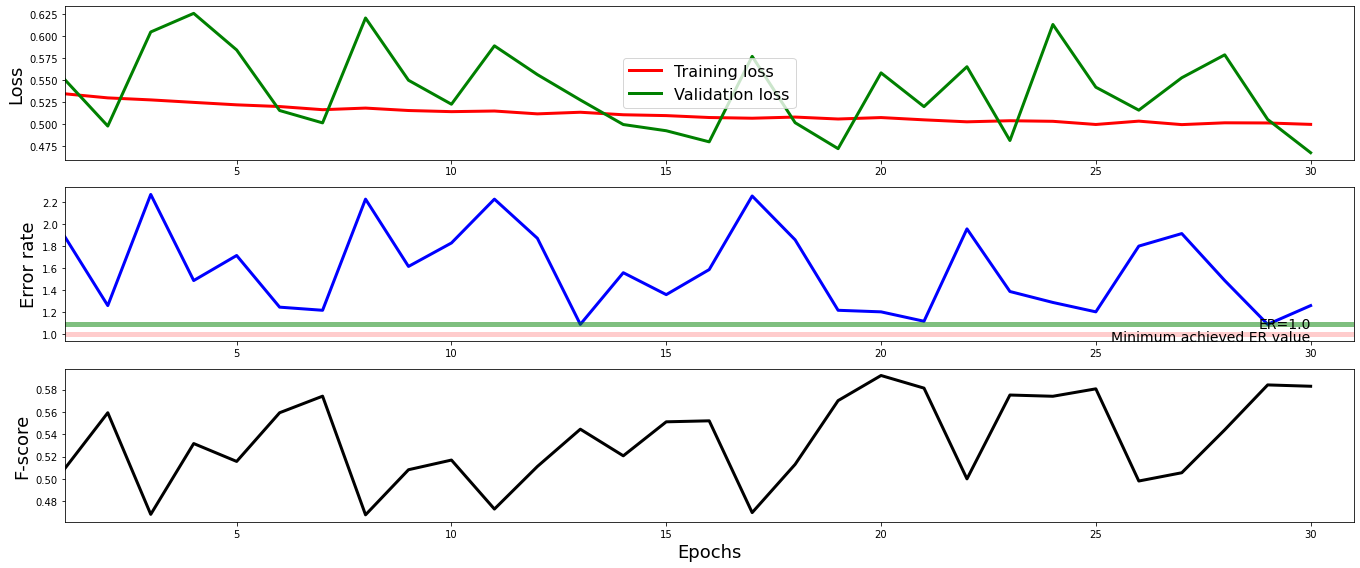

In [41]:
epochs = range(1, len(hist['loss']) + 1)
fig = plt.figure(figsize=(19,8))

plt.subplot(3,1,1)
plt.plot(epochs, hist['loss'], color='red', linewidth=3, label='Training loss')
plt.plot(epochs, hist['val_loss'], color='green', linewidth=3, label='Validation loss')
#plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_loss'])), color='#6aa84f', linewidth=3, label='Validation loss')
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='best', fontsize=16)
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
panel.get_xaxis().set_visible(True)

plt.subplot(3,1,2)
plt.plot(epochs, hist['val_er'], color='blue', linewidth=3, label='Validation Error rate')
plt.axhline(y=1, color='red', linestyle='-', linewidth=5, alpha=0.2)
plt.ylabel('Error rate', fontsize=18)
er_min_index = numpy.argmin(hist['val_er'])
plt.axhline(hist['val_er'][er_min_index], color='green', linestyle='-', linewidth=5, alpha=0.5) #'o', markersize=10, color='red')
plt.annotate('Minimum achieved ER value', xy=(len(hist['loss']),hist['val_er'][er_min_index]-0.15), fontsize=14, ha='right')
plt.annotate('ER=1.0', xy=(len(hist['loss']),1+0.05), fontsize=14, ha='right')
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
panel.get_xaxis().set_visible(True)

plt.subplot(3,1,3)
plt.plot(epochs, hist['val_f1'], color='black', linewidth=3, label='F-score')
plt.ylabel('F-score', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
plt.tight_layout()
plt.show()

# Testing stage

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/crnn_gru_sed_weight/model_seds_direct_script_upto_10_epochs_new.h5') # Load model

# Feature extractor and data sequencer are initialized here also to be able to run only testing stage.
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, 
    win_length_seconds=0.04,  # 40 ms 
    hop_length_seconds=0.02,  # 20 ms
    fs=44100
)

sequence_length = 450                              # 10s/0.02s=250 frames
data_sequencer = dcase_util.data.Sequencer(
    sequence_length=sequence_length
) 

current_fold = 1

## Going through all test material

In [ ]:
# temp = np.ones((2,3))
# temp[1][2] = 5
# print(temp)

In [ ]:
# temp = temp.reshape(1,2,3)

In [ ]:
# print(temp)

In [ ]:
# def binarization(self, probabilities, binarization_type='global_threshold', threshold=0.5, time_axis=1):
#         """Binarization
#         Parameters
#         ----------
#         probabilities : numpy.ndarray
#             Probabilities to be binarized
#         binarization_type : str ('global_threshold', 'class_threshold', 'frame_max')
#         threshold : float
#             Binarization threshold, value of the threshold are replaced with 1 and under with 0.
#             Default value 0.5
#         time_axis : int
#             Axis index for the frames
#             Default value 1
#         Raises
#         ------
#         AssertionError:
#             Unknown binarization_type
#         Returns
#         -------
#         numpy.ndarray
#             Binarized data
#         """

#         if binarization_type not in ['global_threshold', 'class_threshold', 'frame_max']:
#             message = '{name}: Unknown frame_binarization type [{type}].'.format(
#                 name=self.__class__.__name__,
#                 type=binarization_type
#             )

#             self.logger.exception(message)
#             raise AssertionError(message)

#         # Get data_axis
#         if time_axis == 0:
#             data_axis = 1
#         else:
#             data_axis = 0

#         if binarization_type == 'global_threshold':
#             return numpy.array(probabilities >= threshold, dtype=int)

#         elif binarization_type == 'class_threshold' and isinstance(threshold, list):
#             data = []
#             for class_id, class_threshold in enumerate(threshold):
#                 if data_axis == 0:
#                     data.append(numpy.array(probabilities[class_id, :] >= class_threshold, dtype=int))

#                 elif data_axis == 1:
#                     data.append(numpy.array(probabilities[:, class_id] >= class_threshold, dtype=int))

#             if data_axis == 0:
#                 return numpy.vstack(data)

#             elif data_axis == 1:
#                 return numpy.vstack(data).T

#         elif binarization_type == 'frame_max':
#             if data_axis == 0:
#                 return numpy.array((probabilities / numpy.max(probabilities, axis=0)) == 1, dtype=int)

#             elif data_axis == 1:
#                 return numpy.array((probabilities.T / numpy.max(probabilities, axis=1)).T == 1, dtype=int)

In [ ]:
# print(X_train[0,:,:])

In [ ]:
# def find_contiguous_regions(self, activity_array):
#         """Find contiguous regions from bool valued numpy.array.
#         Transforms boolean values for each frame into pairs of onsets and offsets.
#         Parameters
#         ----------
#         activity_array : numpy.array [shape=(t)]
#             Event activity array, bool values
#         Returns
#         -------
#         numpy.ndarray [shape=(2, number of found changes)]
#             Onset and offset indices pairs in matrix
#         """

#         # Find the changes in the activity_array
#         change_indices = numpy.logical_xor(activity_array[1:], activity_array[:-1]).nonzero()[0]

#         # Shift change_index with one, focus on frame after the change.
#         change_indices += 1

#         if activity_array[0]:
#             # If the first element of activity_array is True add 0 at the beginning
#             change_indices = numpy.r_[0, change_indices]

#         if activity_array[-1]:
#             # If the last element of activity_array is True, add the length of the array
#             change_indices = numpy.r_[change_indices, activity_array.size]

#         # Reshape the result into two columns
#         return change_indices.reshape((-1, 2))

In [ ]:
# print(X_train[0,:,:].reshape(1, X_train[0,:,:].shape[0], X_train[0,:,:].shape[1]).shape)

In [ ]:
res = dcase_util.containers.MetaDataContainer(filename=os.path.join(data_storage_path, 'results_sed.csv'))

audio_folder_name = '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/validation_data/validation_wavs'
for audio_filename in os.listdir(audio_folder_name):
    # Load features
    # features = get_feature_matrix(item.filename)
    # features_sequenced = data_sequencer.sequence(features).data
    # input_data = numpy.moveaxis(features_sequenced, 2, 0) # Rearrange axes => (sequence, feature vector, time)
    audio_path = os.path.join(audio_folder_name, audio_filename)
    features, hop_length_seconds = get_feature_matrix_script_features(audio_path)
    #features = features[:,:500]
    input_data = features.reshape(1, features.shape[0], features.shape[1])


    # Get network output
    item_probabilities_seq = model.predict(x=input_data)        # Get per frame probabilities in sequences (3D matrix)
    item_probabilities = numpy.vstack(item_probabilities_seq)   # Merge sequences together (2D matrix)

    # Event activity
    event_activity = dcase_util.data.ProbabilityEncoder().binarization(
        probabilities=item_probabilities,
        binarization_type='global_threshold',
        threshold=0.5
    )
    current_estimated = dcase_util.containers.MetaDataContainer()
    for event_id, event_label in enumerate(['speech', 'music']):
        # Convert active frames into segments and translate frame indices into timestamps
        event_segments = dcase_util.data.DecisionEncoder().find_contiguous_regions(
            activity_array=event_activity[:, event_id]
        ) * 0.03194888178

        # Form event items
        for event in event_segments:
            current_estimated.append(
                {
                    'filename': audio_filename,
                    'onset': event[0],
                    'offset': event[1],
                    'event_label': event_label
                }
            )
            
        # Merge events together from same class which are within 100ms
        current_estimated = current_estimated.process_events(minimum_event_gap=0.5)
        # Remove events which are < 100ms 
        current_estimated = current_estimated.process_events(minimum_event_length=0.5)
        
    # Store result into results container
    res += current_estimated
    
# Save results container
res.save().show(mode='print')

MetaDataContainer :: Class
Filename                            : /content/data/results_sed.csv 
Items                               : 33 
Unique
  Files                             : 12 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Event statistics
  Event label             Count   Tot. Length   Avg. Length   
  --------------------   ------   -----------   -----------   
  music                      16         39.58          2.47   
  speech                     17         42.52          2.50   




# Evaluation

`sed_eval` toolbox is used to get Error rate and F-score for test set:

In [ ]:
print(validation_meta[0].filename)

S1


In [ ]:
res = dcase_util.containers.MetaDataContainer().load(filename=os.path.join(data_storage_path, 'results_sed.csv'))

## Preparing data for evaluation

Prepare reference data and estimated to have filenames in uniform format:

In [ ]:
reference_event_list = validation_meta
estimated_event_list = dcase_util.containers.MetaDataContainer(
    filename=os.path.join(data_storage_path, 'results_sed.csv')
).load()

# for item_id, item in enumerate(reference_event_list):
#   print(item.filename, item_id)
#   # reference_event_list[item_id][f'{filename}'] = os.path.split(item.filename)[-1]

for item_id, item in enumerate(estimated_event_list):
    estimated_event_list[item_id]['filename'] = item.filename.split('.')[0]    

In [ ]:
print(estimated_event_list)

MetaDataContainer :: Class
Filename                            : /content/data/results_sed.csv 
Items                               : 38 
Unique
  Files                             : 12 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Meta data
  Source                  Onset   Offset   Scene             Event             Tags              Identifier   
  --------------------   ------   ------   ---------------   ---------------   ---------------   -----   
  S161                     3.07     8.98   -                 music             -                 -       
  S161                     3.07     3.64   -                 speech            -                 -       
  S161                     8.27    10.00   -                 speech            -                 -       
  S138                     0.38     0.96   -                 m

In [ ]:
print(reference_event_list)

MetaDataContainer :: Class
Items                               : 2160 
Unique
  Files                             : 1020 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Meta data
  Source                  Onset   Offset   Scene             Event             Tags              Identifier   
  --------------------   ------   ------   ---------------   ---------------   ---------------   -----   
  S1                       0.00     5.00   -                 music             -                 -       
  S1                       5.00    10.00   -                 speech            -                 -       
  S2                       0.00     5.00   -                 music             -                 -       
  S2                       5.00    10.00   -                 speech            -                 -       
  S3                 

In [ ]:
# Initialize evaluator with list of event labels to be evaluated and segment length
evaluator = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=['speech', 'music'], 
    time_resolution=0.2                    # 1 second segments
)
# Loop file by file and accumulate intermediate statistics
for filename in reference_event_list.unique_files:
    evaluator.evaluate(
        reference_event_list=reference_event_list.filter(filename=filename),
        estimated_event_list=estimated_event_list.filter(filename=filename)
    ) 
metrics = evaluator.results_overall_metrics()

## Metric values

In [ ]:
log.table(
    column_headers=['Metric', 'Value'],
    cell_data=[
        [
          '<strong>F-score</strong>',
          'Precision',
          'Recall',
          '<strong>Error rate</strong>',
            'Substitutions',
            'Deletions',
            'Insertions'
        ],
        [
            metrics['f_measure']['f_measure']*100.0,
            metrics['f_measure']['precision']*100.0,
            metrics['f_measure']['recall']*100.0,
            metrics['error_rate']['error_rate'],
            metrics['error_rate']['substitution_rate'],
            metrics['error_rate']['deletion_rate'],
            metrics['error_rate']['insertion_rate'],
        ]
    ],
    row_separators=[3],
    scaling=130
)

Metric,Value
F-score,1.46
Precision,49.45
Recall,0.74
Error rate,1.00
Substitutions,0.00
Deletions,0.99
Insertions,0.00


## Class-wise metrics

In [ ]:
class_metrics = evaluator.results_class_wise_metrics()
Nref = []
Nsys = []
Fscore=[]
for event_label in list(class_metrics.keys()):
    Nref.append(class_metrics[event_label]['count']['Nref'])
    Nsys.append(class_metrics[event_label]['count']['Nsys'])
    Fscore.append(class_metrics[event_label]['f_measure']['f_measure']*100.0)
log.table(
    column_headers=['Event', 'Nref', 'Nsys', 'Fscore'],
    cell_data=[
        list(class_metrics.keys()),Nref,Nsys,Fscore
    ],
    column_types=['str25', 'int', 'int', 'float2'],
    column_separators=[0,2],
    scaling=130
)

Event,Nref,Nsys,Fscore
speech,15750,286,1.40
music,14250,237,1.10


Output directly from `sed_eval` evaluator:

In [ ]:
print(evaluator)    

Segment based metrics
  Evaluated length                  : 116.19 sec
  Evaluated files                   : 12 
  Segment length                    : 200.00 ms

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 41.85 %
    Precision                       : 32.61 %
    Recall                          : 58.40 %
  Error rate
    Error rate (ER)                 : 1.39 
    Substitution rate               : 0.24 
    Deletion rate                   : 0.18 
    Insertion rate                  : 0.97 
  Accuracy
    Sensitivity                     : 58.40 %
    Specificity                     : 40.96 %
    Balanced accuracy               : 49.68 %
    Accuracy                        : 46.69 %

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 41.59 %
    Precision                       : 33.30 %
    Recall                          : 59.44 %
  Error rate
    Error rate (ER)                 : 1.64 
    Deletion rate